# 2. Diabetes - model data with outliers and class imbalance



In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from joblib import dump
from sklearn.tree import export_graphviz
from sklearn import tree

In [20]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [22]:
import sys
sys.path.append("..\code_files")
from functions import cross_validation_fun

Preprocessed dataset was imported to *data_orgin* Data Frame.

In [23]:
data_orgin = pd.read_csv("..\code_files\data\export_dataframe.csv")

In [24]:
data_orgin.shape

(768, 9)

In [25]:
data_orgin.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.00,35.00,201.62,33.600,0.627,50.0,1.0
1,1.0,85.0,66.00,29.00,57.02,26.600,0.351,31.0,0.0
2,8.0,183.0,64.00,19.03,233.41,23.300,0.672,32.0,1.0
3,1.0,89.0,66.00,23.00,94.00,28.100,0.167,21.0,0.0
4,0.0,137.0,40.00,35.00,168.00,43.100,2.288,33.0,1.0
5,5.0,116.0,74.00,25.88,112.35,25.600,0.201,30.0,0.0
6,3.0,78.0,50.00,32.00,88.00,31.000,0.248,26.0,1.0
7,10.0,115.0,75.32,32.10,163.27,35.300,0.134,29.0,0.0
8,2.0,197.0,70.00,45.00,543.00,30.500,0.158,53.0,1.0
9,8.0,125.0,96.00,37.30,271.77,41.385,0.232,54.0,1.0


In [26]:
X = data_orgin.iloc[:, :-1]
y = data_orgin.iloc[:,-1]
col = data_orgin.columns

Standard scaler model was applied to standarized data in order to use models based on  distance calculation (k-Nearest Neighbours algorithm).

In [27]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [28]:
X = pd.DataFrame(data = X, columns = col[:-1])
data = X.join(y)


## 2.1. The Interquartile Range (IQR) algorithm

IQR method was used to detect outliers in Diabetes dataset. In this method the first and the third quartiles need to be calculated. The Interquartile range  for each column was calculated and presented below.

In [29]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Pregnancies                 1.484832
Glucose                     1.378719
BloodPressure               1.314442
SkinThickness               1.430027
Insulin                     1.017346
BMI                         1.320921
DiabetesPedigreeFunction    1.155195
Age                         1.446492
Outcome                     1.000000
dtype: float64


If data instances fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR they are treated as outliers. Those instances were saved as Data Frame named *outliers*. There are 92 such instances identified.

In [30]:
outliers = data[((data<(Q1-1.5 * IQR))|(data> (Q3 + 1.5*IQR))).any(axis=1)]

In [31]:
outliers.shape

(92, 9)

Outliers were excluded from *data* and saved in *df* Data Frame

In [32]:
df = data[~((data<(Q1-1.5 * IQR))|(data> (Q3 + 1.5*IQR))).any(axis=1)]

In [33]:
df.shape

(676, 9)

The outliers instances were oversampled with replecement and added to dataset.

In [34]:
resample_data = outliers.sample(n=276, replace = True, random_state = 19)
resample_data.shape

(276, 9)

In [35]:
data_IQR = df.append(resample_data)
data_IQR.shape

(952, 9)

In [36]:
data_IQR.groupby('Outcome').size()

Outcome
0.0    585
1.0    367
dtype: int64

## 2.2. SMOTE algorithm

To obtained balanced dataset Synthetic Minority Oversampling TEchnique (SMOTE) was applied.

In [37]:
X_iqr = data_IQR.iloc[:, :-1]
y_iqr = data_IQR.iloc[:,-1]
over = SMOTE(random_state = 100)
X_smote, y_smote = over.fit_resample(X_iqr, y_iqr)
data_smote = X_smote.join(y_smote)

In [38]:
data_smote.shape

(1170, 9)

In [39]:
data_smote.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.865309,-0.032098,0.609373,0.442585,0.169330,0.468492,1.425995,1.0
1,-0.844885,-1.202769,-0.525014,-0.003495,-0.971815,-0.846763,-0.365061,-0.190672,0.0
2,1.233880,2.014242,-0.689319,-1.021879,0.753538,-1.325778,0.604397,-0.105584,1.0
3,-0.844885,-1.071462,-0.525014,-0.616364,-0.610096,-0.629029,-0.920763,-1.041549,0.0
4,0.342981,-0.185143,0.132207,-0.322187,-0.430606,-0.991919,-0.818079,-0.275760,0.0


Dataset was balanced. There are 585 instances in both classes.

In [40]:
data_smote.groupby('Outcome').size()

Outcome
0.0    585
1.0    585
dtype: int64

## 2.3. Model the data

The four classifiers (SVM, Gaussian NB, Decision Tree and Random Forest) were trained and also four performance metrics were used to evaluate and compare different models. To evaluate models and ensure that the results are unbiased k-fold cross validation was applied. Exact folds generated from orginal data were taken to evaluate classifier models trained with preprocessed data. Training process was illustrated below: 

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S093336571830681X-gr3.jpg">

### 2.3.1. Support Vector Machines (SVM) model

SVM algorithm finds hyperplane to separate two classes with the highest possible margins. In case of non-linear problem kernel function is used to take it and transform into a linear problem. <br>
Radial Basis Function (RBF) kernel was used and it is based on the squared Euclidean distance between two feature vectors (2 points) and gamma value which is a scalar that defines how much influence a single training example (point) has. <br><br>
$$ K(x, x') = e^{-\gamma||x-x'||^{2}}  $$

In [41]:
classifier_SVM = SVC(kernel = 'rbf', random_state = 0)
cross_validation_fun(k=10, training_data = data_smote, test_data = data, model = classifier_SVM)

Avg accuracy test : 0.8060833902939166
Avg precision score : 0.6233815878838855
Avg recall score : 0.8232209454488866
Avg f1 score : 0.7410927775487247


(0.8060833902939166, 0.6233815878838855)

### 2.3.2. Naive Bayes

Naive Bayes classifier is based on Bayes theorem: <br>

$$ P(y|X) = \frac{P(X|y)P(y)}{P(X)} $$

$y$ - class variable <br>
$X = (x_{1}, x_{2}, x_{3}, ..., x_{n})$ - represents all features

There are two assumptions: 
* All variables are independent
* All the predictors have an equal effect on the outcome

The biggest disadvantage of this classifier is that the requirement of predictors to be independent

In [43]:
classifier_NB = GaussianNB()
cross_validation_fun(k=10, training_data = data_smote, test_data = data, model = classifier_NB)

Avg accuracy test : 0.7616883116883117
Avg precision score : 0.5500904380408945
Avg recall score : 0.6437198525874995
Avg f1 score : 0.6476355388829356


(0.7616883116883117, 0.5500904380408945)

### 2.3.3 Decision Tree Classifier

The aim of Decision Tree Classifier is to predict class by learning simple decision rules inferred from training data.
It starts from the *root* of the tree and compares the values of the root attribute with the record’s attribute and then follows the branch corresponding to that value and goes to the next node. <br>
Criterion *'entropy'* means that Information Gain was choosen as attribute selection measure to determine breakpoints for tuples on a given node. <br>
Maximum depth ( the longest path from the tree root to a leaf) was choosen arbitrarily and set to 5.

In [46]:
classifier_DT = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5, random_state = 0)
cross_validation_fun(k=10, training_data = data_smote, test_data = data, model = classifier_DT)

Avg accuracy test : 0.7955058099794943
Avg precision score : 0.6164878066781333
Avg recall score : 0.8574536471154118
Avg f1 score : 0.7415213428030886


(0.7955058099794943, 0.6164878066781333)

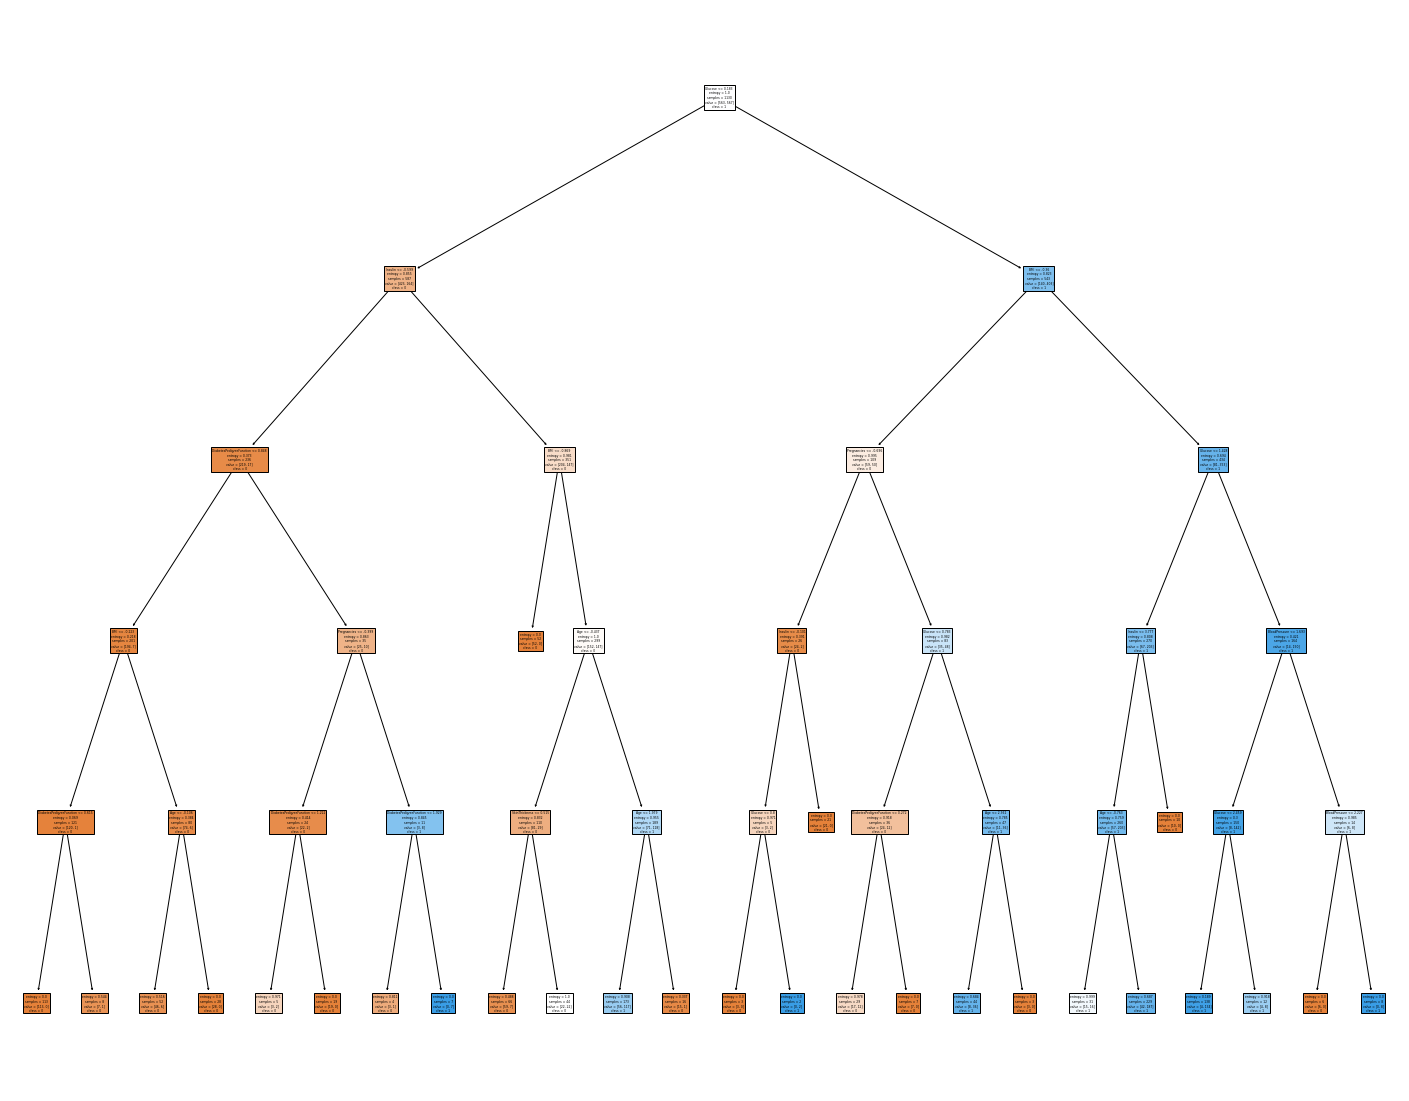

In [47]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier_DT, feature_names = data_smote.columns, class_names = ["0","1"], filled=True)
fig.savefig("decistion_tree.png")

### 2.3.4. Random Forest Classifier

Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. The default number of forest (100) was choosen and criterion was set to 'gini' (it is default). Max depth was set to 5.

In [48]:
classifier_RF = RandomForestClassifier(max_depth=5, random_state = 0)
cross_validation_fun(k=10, training_data = data_smote, test_data = data, model = classifier_RF)

Avg accuracy test : 0.8060833902939167
Avg precision score : 0.6291389995338913
Avg recall score : 0.8661925062954475
Avg f1 score : 0.7530780660666746


(0.8060833902939167, 0.6291389995338913)

There was one tree selected from the forest and visualize below as an example.

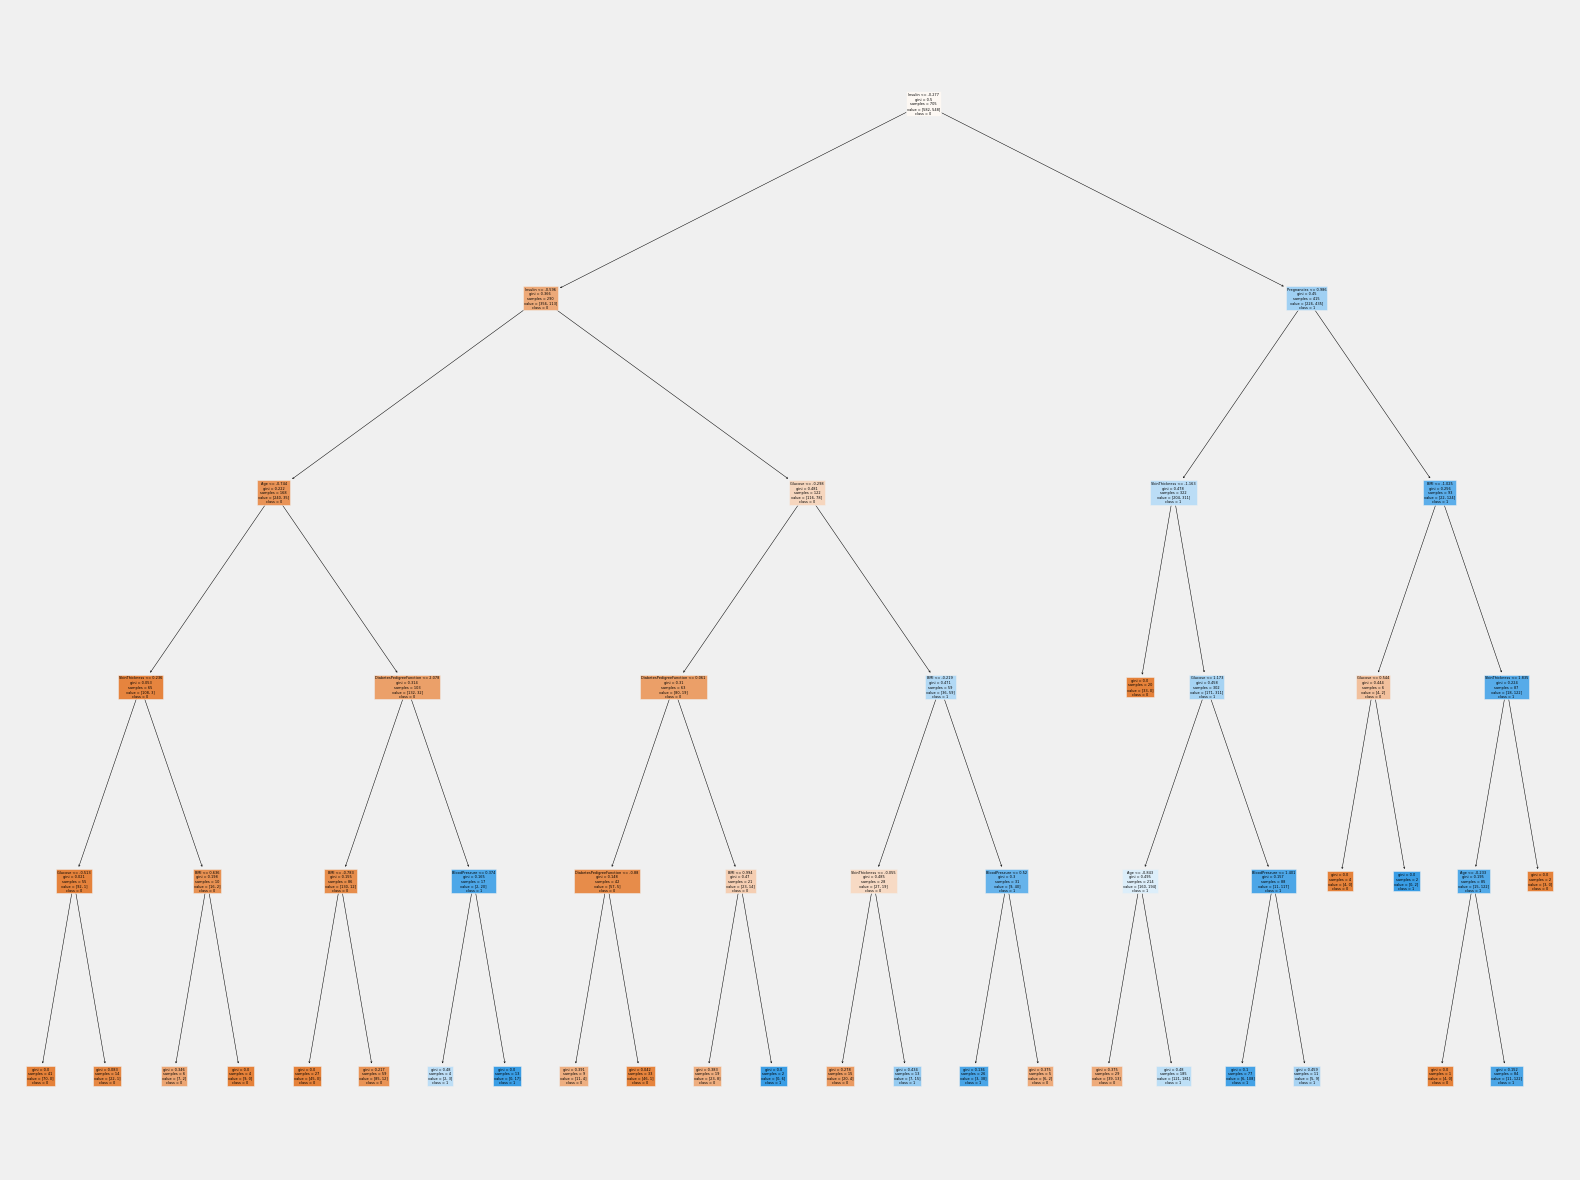

In [69]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier_RF.estimators_[0], feature_names = data_smote.columns, class_names = ["0","1"], filled=True)
fig.savefig("random_forest_decistion_tree.png")

Variable importances were calculated. Those values indicate how much including a particular variable improves the prediction.

In [51]:
feature_imp = pd.Series(classifier_RF.feature_importances_,index=data.columns[:-1]).sort_values(ascending=False)
feature_imp

Glucose                     0.295825
Insulin                     0.199590
BMI                         0.150939
Age                         0.102783
SkinThickness               0.075844
DiabetesPedigreeFunction    0.070648
Pregnancies                 0.066932
BloodPressure               0.037439
dtype: float64

The most important variable is Glucose with almost 0.3 importance score. Variables above 0.1 importance score are Insulin, BMI and Age. Skin Thickness, DiabetesPedigreeFunction, Pregnancies and Blood Pressure have feature importance score below 0.1.

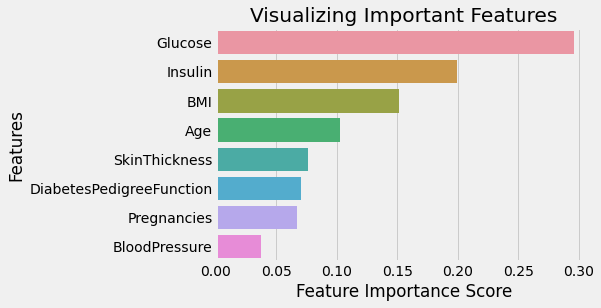

In [61]:
plt.style.use('fivethirtyeight')
sns.barplot(x=feature_imp, y=feature_imp.index);
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title("Visualizing Important Features");

### 2.3.5. Model comparison

Four models were validated using k-fold cross-validation. The below metrics: Accuracy, Precision, Recall and F1 score were calculated in order to compare those classifiers.

| Model         | Accuracy | Precision | Recall  | F1 score |
|---------------|----------|-----------|---------|----------|
| SVM           |   0.81   |    0.62   |   0.82  |   0.74   |
| Naive Bayes   |   0.76   |    0.55   |   0.64  |   0.65   |
| Decision Tree |   0.80   |    0.62   |   0.86  |   0.74   |
| Random Forest |   0.81   |    0.63   |   0.87  |   0.75   |

The best accuracy (81 %) was for SVM model and Random Forest classifier. Precision metric indicate how often it is correct when the model predicts positive (class marked as '1').<br> Random Forest has the highest precision equal to 0.63. Recall metric represents ratio of true positives to total (actual) positives in the data. In case of Diabetes this metric is crutial because the occurrence of false negatives is unacceptable rather than the occurrence of false positives. The highest recall was calculated for Random Forest Classifier. This model was selected as the most accurate to predict diabetes. <br>
Value of F1 score might be a confirmation that the best model was choosen. F1 score is equal to 0.75 and it is the highest value among all classifiers used. <br>

Random Forest Classifier was saved as prediction model and it will be used in web application.

In [72]:
with open("model.pkl", "wb") as file:
    pickle.dump(classifier_RF, file)
file.close()

In [73]:
dump(sc, "scaler.joblib")

['scaler.joblib']